## Read Random Search Results

In [1]:
import pandas as pd

trial_results = pd.read_csv("./hpo_search/trial_results.csv")
trial_results

,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,weight_decay,per_device_train_batch_size,model,learning_rate,heads,ff_dropout,dim,depth,attn_dropout
0,0.451050,0.809922,0.744007,0.630243,0.668017,31.7386,2928.990,366.147,20.0,0.01000,64,TabTransformer,0.0001,8,0.10000,16,4,0.00001
1,0.510862,0.782503,0.698398,0.568039,0.598179,58.0422,1601.628,200.216,20.0,0.00001,1024,TabTransformer,0.0001,9,0.00001,64,9,0.00100
2,0.199807,0.920548,0.890416,0.865342,0.877207,34.2872,2711.276,338.931,20.0,0.00100,512,TabTransformer,0.0010,3,0.00100,64,4,0.00001
3,0.309021,0.877864,0.834988,0.749634,0.783538,63.5316,1463.241,182.917,20.0,0.10000,32,TabTransformer,0.0010,8,0.00100,16,10,0.10000
4,0.306550,0.878714,0.833049,0.783366,0.805206,53.0715,1751.638,218.969,20.0,0.01000,64,TabTransformer,0.0010,10,0.10000,8,8,0.00001
5,0.556407,0.761311,0.666861,0.531779,0.558767,31.7324,2929.559,366.219,20.0,0.01000,256,TabTransformer,0.0001,3,0.00100,8,4,0.00001
6,0.263186,0.895818,0.857730,0.803577,0.827477,15.9986,5810.644,726.377,20.0,0.00001,32,FTTransformer,0.0010,8,0.01000,16,1,0.01000
7,0.491690,0.785622,0.740633,0.599549,0.637054,16.0428,5794.607,724.373,20.0,0.00100,32,FTTransformer,0.0001,1,0.00100,64,1,0.10000
8,0.184602,0.927013,0.900475,0.879031,0.889325,32.0287,2902.459,362.831,20.0,0.00100,1024,TabTransformer,0.0010,3,0.00001,128,4,0.00001
9,0.200501,0.920989,0.893410,0.866048,0.878891,52.9757,1754.804,219.365,20.0,0.00001,512,TabTransformer,0.0010,5,0.10000,64,8,0.01000


## Find Best Hyperparameters

In [3]:
best_param = trial_results.loc[trial_results["eval_accuracy"].idxmax()].to_dict()
best_param

{'eval_loss': 0.1179541945457458,
 'eval_accuracy': 0.9520771928314796,
 'eval_precision': 0.9231518972840116,
 'eval_recall': 0.9248362874659396,
 'eval_f1': 0.9236776211992542,
 'eval_runtime': 42.6272,
 'eval_samples_per_second': 2180.815,
 'eval_steps_per_second': 272.619,
 'epoch': 20.0,
 'weight_decay': 0.01,
 'per_device_train_batch_size': 128,
 'model': 'FTTransformer',
 'learning_rate': 0.001,
 'heads': 8,
 'ff_dropout': 0.1,
 'dim': 32,
 'depth': 6,
 'attn_dropout': 0.1}

## Read Dataset Splits

In [4]:
from tfcovertype.dataset import CoverTypeDataset
train_dataset, val_dataset, test_dataset = CoverTypeDataset.get_dataset_splits(
    test_size=0.2,
    val_size=0.2,
    random_state=42,
)

/home/ssapkota/.virtualenvs/cap5610/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Find Best Checkpoint

In [9]:
import os
import json

latest_checkpoint = sorted([file for file in os.listdir("./hpo_search/") if file.startswith("checkpoint-")])[-1]
with open(f"./hpo_search/{latest_checkpoint}/trainer_state.json", "r") as fr:
    best_checkpoint = json.load(fr)['best_model_checkpoint']
best_checkpoint

'hpo_search/checkpoint-181600'

## Load Best Model

In [5]:
from tfcovertype.models.fttransformer import FTTransformerClassifier
from tfcovertype.models.tabtransformer import TabTransformerClassifier

if best_param["model"] == "TabTransformer":
    model = TabTransformerClassifier.from_pretrained("./hpo_search/checkpoint-181600")
else:
    model = FTTransformerClassifier.from_pretrained("./hpo_search/checkpoint-181600")

In [10]:
from torch.utils.data import ConcatDataset
from transformers import Trainer, TrainingArguments

from tfcovertype.utils import compute_metrics


training_args = TrainingArguments(
    output_dir=".",
    report_to="none",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    logging_strategy="epoch",
    learning_rate=best_param["learning_rate"],
    weight_decay=best_param["weight_decay"],
    per_device_train_batch_size=best_param["per_device_train_batch_size"],
    num_train_epochs=50,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ConcatDataset([train_dataset, val_dataset]),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Evaluate on the Test Set

In [11]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.08393466472625732, 'eval_model_preparation_time': 0.0011, 'eval_accuracy': 0.9664036212490211, 'eval_precision': 0.942176709419863, 'eval_recall': 0.9471293538567968, 'eval_f1': 0.9445748809068849, 'eval_runtime': 60.6438, 'eval_samples_per_second': 1916.156, 'eval_steps_per_second': 239.53}


In [13]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
print(classification_report(y_true=predictions.label_ids, y_pred=predictions.predictions.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     42368
           1       0.97      0.97      0.97     56661
           2       0.97      0.96      0.97      7151
           3       0.91      0.89      0.90       549
           4       0.89      0.93      0.91      1899
           5       0.94      0.94      0.94      3473
           6       0.96      0.97      0.96      4102

    accuracy                           0.97    116203
   macro avg       0.94      0.95      0.94    116203
weighted avg       0.97      0.97      0.97    116203



## Plot Learning Curve

In [10]:
import json

with open('./hpo_search/checkpoint-181600/trainer_state.json', 'r') as f:
    log = json.load(f)

In [11]:
history = pd.DataFrame(log['log_history'])
history = history.groupby('epoch').apply(lambda x: x.ffill().bfill().iloc[0]).reset_index(drop=True)
history = history.rename(columns={'loss': 'train_loss',})

/tmp/ipykernel_583386/2506473636.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



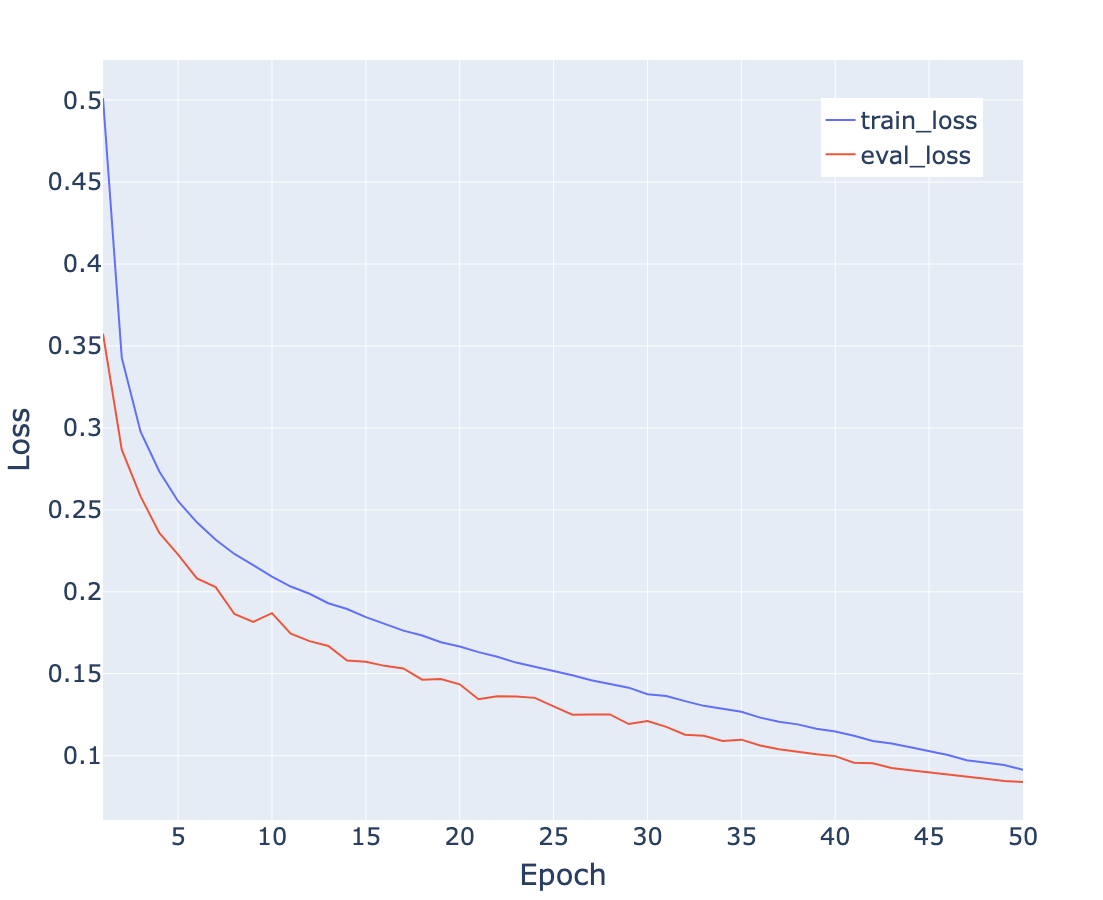

In [30]:
import plotly.express as px

fig = px.line(
    history, x='epoch', y=['train_loss', 'eval_loss'],
    labels={'epoch': 'Epoch', 'value': 'Loss', 'variable': '',},
    # title='Training and Validation Loss'
)
# Increase the size of the plot
fig.update_layout(
    width=900,  # Set the width (in pixels)
    height=900,  # Set the height (in pixels)
    font=dict(size=24),
    legend=dict(x=0.78, y=0.95)
)

# Show the heatmap
fig.show()


## Plot Confusion Matrix

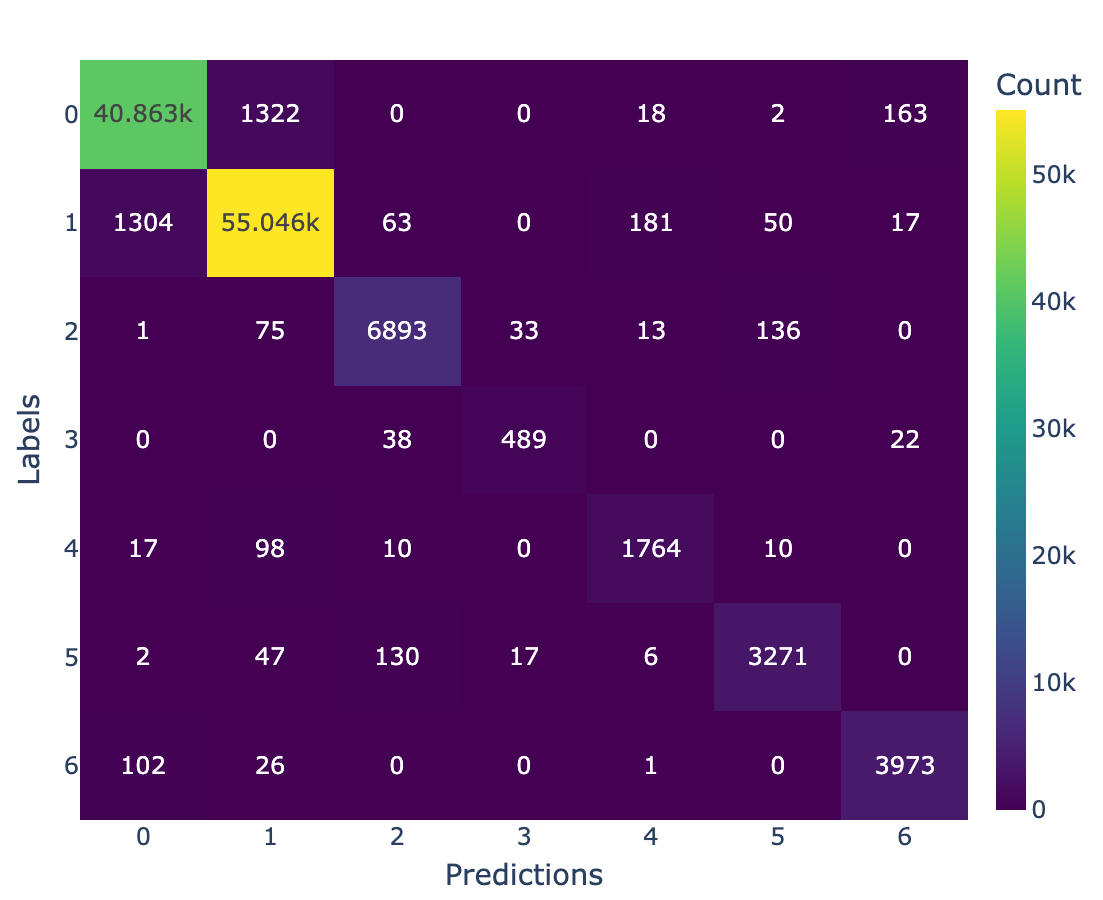

In [22]:
conf_matrix = pd.crosstab(
    pd.Series(predictions.label_ids, name='Labels'),
    pd.Series(predictions.predictions.argmax(axis=-1), name='Predictions'),
)
# Plot a heatmap using Plotly
fig = px.imshow(
    conf_matrix,
    labels=dict(x="Predictions", y="Labels", color="Count"),
    x=conf_matrix.columns,
    y=conf_matrix.index,
    text_auto=True,
    color_continuous_scale="Viridis",
    # title="Confusion Matrix Heatmap"
)

# Increase the size of the plot
fig.update_layout(
    width=900,  # Set the width (in pixels)
    height=900,  # Set the height (in pixels)
    font=dict(size=24),
)

# Show the heatmap
fig.show()